# Web Traffic Time Series Forecasting

- 각 일자별/아티클 별 웹 트레픽을 예측
- 평가 지표: SMAPE(Symmetric Mean Absolute Percentage Error)
$$ SMAPE = (\frac{1}{N} \Sigma_{i=1}^N \frac{|actual-forecast|}{(|actual|+|forecast|)/2}*100 $$

## 1. Introduction

### load data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/web-traffic-time-series-forecasting/sample_submission_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/sample_submission_1.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/train_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/key_1.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/key_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from prophet import Prophet
import matplotlib.pyplot as plt
import math as math
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 87 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,956 kB/s)   
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
Selecting previously unselected package fonts-nanum.
(Reading database ... 129184 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers 

In [4]:
plt.rc('font', family='NanumBarunGothic')

In [5]:
!unzip -qq ../input/web-traffic-time-series-forecasting/key_1.csv.zip
!unzip -qq ../input/web-traffic-time-series-forecasting/key_2.csv.zip
!unzip -qq ../input/web-traffic-time-series-forecasting/train_1.csv.zip
!unzip -qq ../input/web-traffic-time-series-forecasting/train_2.csv.zip
!unzip -qq ../input/web-traffic-time-series-forecasting/sample_submission_1.csv.zip
!unzip -qq ../input/web-traffic-time-series-forecasting/sample_submission_2.csv.zip

In [6]:
train = pd.read_csv("/kaggle/working/train_1.csv")
keys = pd.read_csv("/kaggle/working/key_1.csv")
ss = pd.read_csv("/kaggle/working/sample_submission_1.csv")

In [7]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [8]:
train.shape

(145063, 551)

### 결측치 확인

In [9]:
print('데이터 개수:', train.shape[0], '\n')
empty_sample = train[train.isnull().any(axis=1)]
print('1개 이상의 결측치를 가진 데이터:', empty_sample.shape[0])

데이터 개수: 145063 

1개 이상의 결측치를 가진 데이터: 27786


In [10]:
empty_sample.iloc[np.r_[0:10, len(empty_sample)-10:len(empty_sample)]]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
6,91Days_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,7.0,33.0,8.0,11.0,4.0,15.0,6.0,8.0,6.0
10,ASTRO_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,11.0,38.0,85.0,79.0,30.0,14.0,10.0,38.0,12.0,51.0
13,AlphaGo_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,13.0,14.0,17.0,19.0,56.0,21.0,13.0,21.0,11.0
19,B-PROJECT_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,26.0,10.0,5.0,5.0,11.0,10.0,4.0,8.0,6.0
24,BLACK_PINK_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,56.0,39.0,65.0,78.0,143.0,96.0,63.0,28.0,75.0
27,Beautiful_Mind_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,8.0,6.0,7.0,2.0,11.0,11.0,29.0,12.0,14.0
37,Dear_My_Friends_zh.wikipedia.org_all-access_sp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,12.0,8.0,12.0,3.0,10.0,21.0,6.0,8.0,9.0
38,Doctors_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,19.0,175.0,17.0,21.0,30.0,65.0,70.0,18.0,68.0
48,Fantastic_Duo_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,16.0,15.0,11.0,10.0,7.0,12.0,9.0,8.0,10.0


### 데이터 시각화

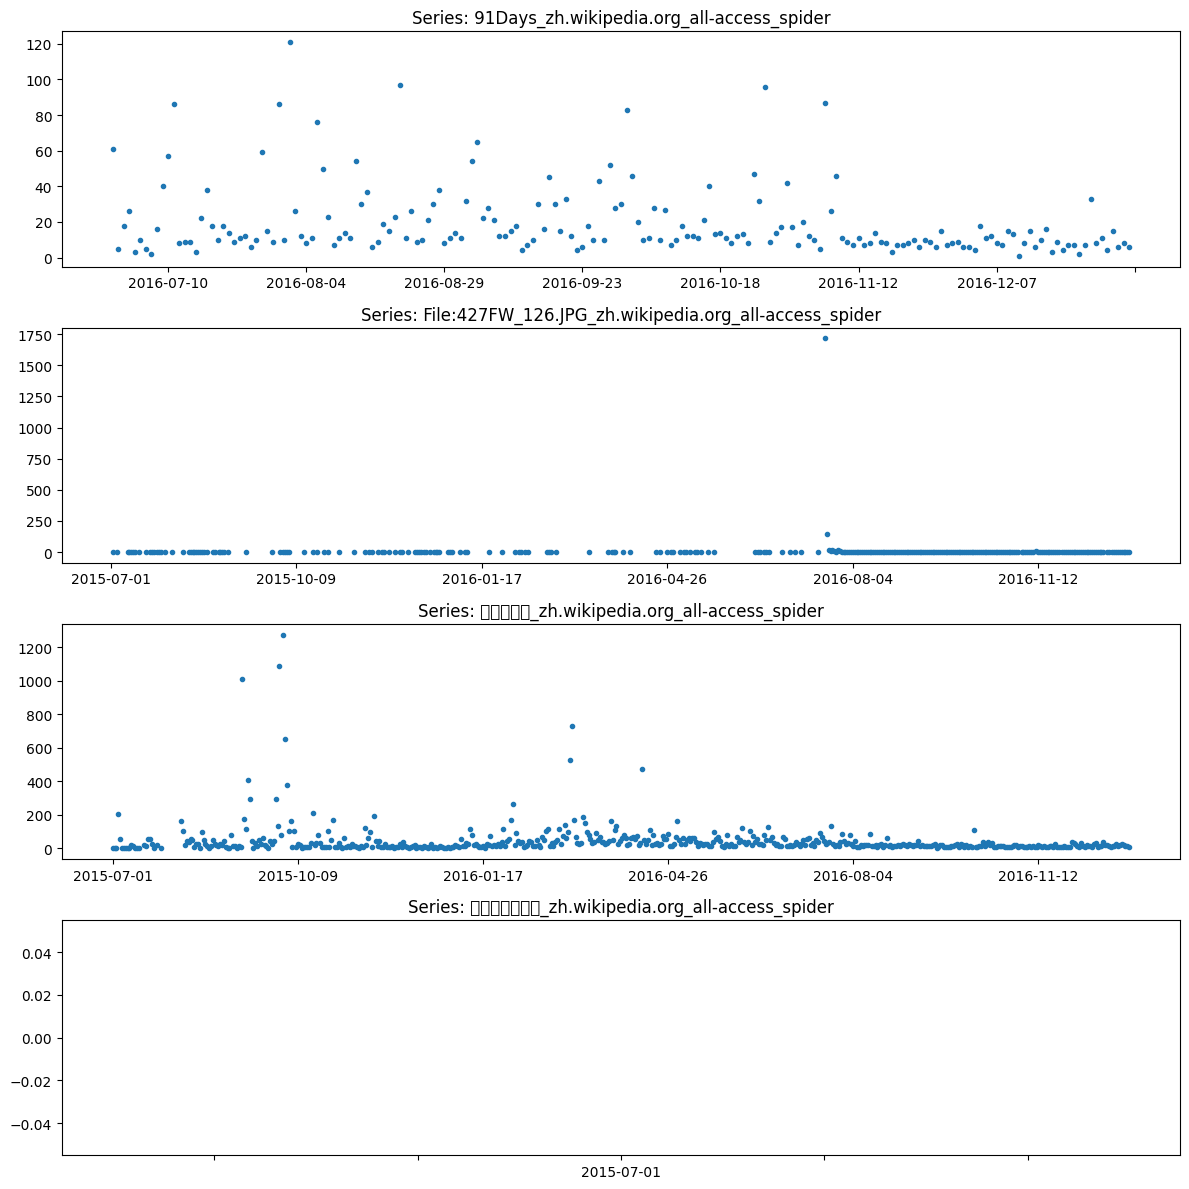

In [11]:
def plot_time_series(df, row_num, start_col = 1, ax=None):
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=(10,6))
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()

    series_title = df.iloc[row_num,0]
    sample_series = df.iloc[row_num, start_col:]
    sample_series.plot(style=".", ax=ax)
    ax.set_title("Series: %s"%series_title)

fig, axs = plt.subplots(4,1,figsize=(12,12))
plot_time_series(empty_sample, 1, ax=axs[0])
plot_time_series(empty_sample, 10, ax=axs[1])
plot_time_series(empty_sample, 100, ax=axs[2])
plot_time_series(empty_sample, 1005, ax=axs[3])

plt.tight_layout()

## 2. Data transformation and helper functions

### article names and metadata

In [12]:
# 위키피디아 문서 이름 뽑아내는 함수인듯
import re

def breakdown_topic(str):
    m = re.search('(.*)\_(.*).wikipedia.org\_(.*)\_(.*)', str)
    if m is not None:
        return m.group(1), m.group(2), m.group(3), m.group(4)
    else:
        return "", "", "", ""


print(breakdown_topic("Рудова,_Наталья_Александровна_ru.wikipedia.org_all-access_spider"))
print(breakdown_topic("台灣災難列表_zh.wikipedia.org_all-access_spider"))
print(breakdown_topic("File:Memphis_Blues_Tour_2010.jpg_commons.wikimedia.org_mobile-web_all-agents"))

('Рудова,_Наталья_Александровна', 'ru', 'all-access', 'spider')
('台灣災難列表', 'zh', 'all-access', 'spider')
('', '', '', '')


In [13]:
# 페이지명 칼럼에서 주제/언어/액세스방법/타입 추출

page_details = train.Page.str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<type>.*)')

page_details.head(10)

,topic,lang,access,type
0,2NE1,zh,all-access,spider
1,2PM,zh,all-access,spider
2,3C,zh,all-access,spider
3,4minute,zh,all-access,spider
4,52_Hz_I_Love_You,zh,all-access,spider
5,5566,zh,all-access,spider
6,91Days,zh,all-access,spider
7,A'N'D,zh,all-access,spider
8,AKB48,zh,all-access,spider
9,ASCII,zh,all-access,spider


In [14]:
unique_topic = page_details["topic"].unique()
print(unique_topic)
print("토픽의 개수:", unique_topic.shape[0])

['2NE1' '2PM' '3C' ... 'Eine_Reihe_betrüblicher_Ereignisse_(Fernsehserie)'
 'ジャック・リーチャー' 'マイク眞木']
토픽의 개수: 42213


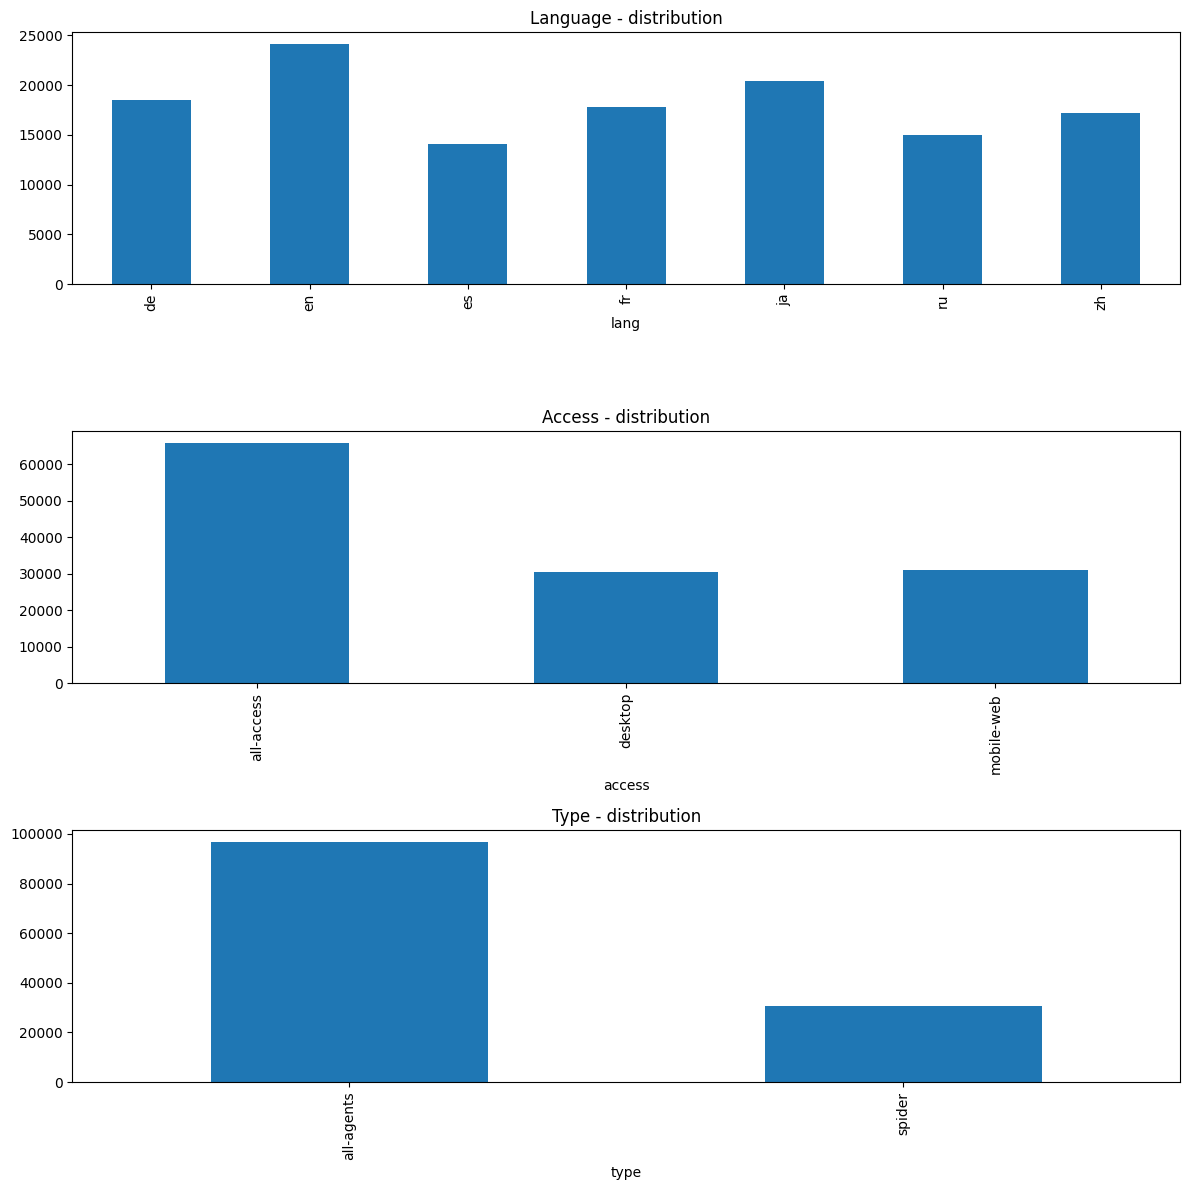

In [15]:
fig, axs = plt.subplots(3,1,figsize=(12,12))

page_details["lang"].value_counts().sort_index().plot.bar(ax=axs[0])
axs[0].set_title('Language - distribution')

page_details['access'].value_counts().sort_index().plot.bar(ax=axs[1])
axs[1].set_title('Access - distribution')

page_details['type'].value_counts().sort_index().plot.bar(ax=axs[2])
axs[2].set_title('Type - distribution')

plt.tight_layout()

### train-test split

In [16]:
train_df = pd.concat([page_details, train], axis=1)

def get_train_validate_set(train_df, test_percent):
    train_end = math.floor((train_df.shape[1]-5) * (1-test_percent))
    train_ds = train_df.iloc[:, np.r_[0,1,2,3,4,5:train_end]]
    test_ds = train_df.iloc[:, np.r_[0,1,2,3,4, train_end: train_df.shape[1]]]

    return train_ds, test_ds

X_train, y_train = get_train_validate_set(train_df, 0.1)

print("The training set sample:")
print(X_train[0:10])
print("The validation set sample:")
print(y_train[:10])

The training set sample:
              topic lang      access    type  \
0              2NE1   zh  all-access  spider   
1               2PM   zh  all-access  spider   
2                3C   zh  all-access  spider   
3           4minute   zh  all-access  spider   
4  52_Hz_I_Love_You   zh  all-access  spider   
5              5566   zh  all-access  spider   
6            91Days   zh  all-access  spider   
7             A'N'D   zh  all-access  spider   
8             AKB48   zh  all-access  spider   
9             ASCII   zh  all-access  spider   

                                                Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-acces

## 3. Forecast methods

In [17]:
def extract_series(df, row_num, start_idx):
    y = df.iloc[row_num, start_idx:]
    df = pd.DataFrame( { 'ds': y.index, 'y': y.values})
    return df

### SMAPE

https://www.kaggle.com/code/cpmpml/smape-weirdness  
데이터가 0일 떄 SMAPE값은 optimize하기 힘들다는 특징을 가짐

In [18]:
def smape(predict, actual, debug=False):
    actual = actual.fillna(0)  # actual이 null일 경우 0으로 대치
    data = pd.concat([predict, actual], axis=1, keys=['predict', 'actual'])
    data = data[data.actual.notnull()]
    if debug:
        print('debug', data)
    evals = abs(data.predict - data.actual) * 1.0 / (abs(data.predict) + abs(data.actual)) * 2
    evals[evals.isnull()] = 0
    result = np.sum(evals) / len(data)

    return result


testing_series_1 = X_train.iloc[0, 5:494]
testing_series_2 = X_train.iloc[0, 5:494].shift(-1)  # 데이터를 한 행씩 당김..
testing_series_3 = X_train.iloc[1, 5:494]
testing_series_4 = pd.Series([0,0,0,0])



In [19]:
testing_series_1

2015-07-01    18.0
2015-07-02    11.0
2015-07-03     5.0
2015-07-04    13.0
2015-07-05    14.0
              ... 
2016-10-27    20.0
2016-10-28    12.0
2016-10-29    19.0
2016-10-30    50.0
2016-10-31    16.0
Name: 0, Length: 489, dtype: object

In [20]:
testing_series_2

2015-07-01    11.0
2015-07-02     5.0
2015-07-03    13.0
2015-07-04    14.0
2015-07-05     9.0
              ... 
2016-10-27    12.0
2016-10-28    19.0
2016-10-29    50.0
2016-10-30    16.0
2016-10-31    None
Name: 0, Length: 489, dtype: object

In [21]:
random_series_1 = pd.Series(np.repeat(3, 500))   # 모든 값이 3
random_series_2 = pd.Series(np.random.normal(3, 1, 500))  # 정규분포 3 사이의 랜덤 데이터
random_series_3 = pd.Series(np.random.normal(500, 20, 500))  # 500 사이의 정규분포 랜덤 데이터
random_series_4 = pd.Series(np.repeat(500, 500))

print("\nSMAPE score to predict a constant array of 3")
print("Score (same series): %.3f" % smape(random_series_1, random_series_1))
print("Score (same series - 1) %.3f" % smape(random_series_1, random_series_1-1))
print("Score (same series + 1) %.3f" % smape(random_series_1, random_series_1+1))

# testing 2 same series shift by one
print("\nSMAPE score to predict a array of normal distribution around 3")
print("Score (random vs mean) %.3f" % smape(random_series_2, random_series_1))
print("Score (random vs mean-1) %.3f" % smape(random_series_2, random_series_2-1))
print("Score (random vs mean+1) %.3f" % smape(random_series_2, random_series_2+1))
print("Score (random vs mean*0.9) %.3f" % smape(random_series_2, random_series_2*0.9))
print("Score (random vs mean*1.1) %.3f" % smape(random_series_2, random_series_2*1.1))

# testing 3 totally different series
print("\nSMAPE score to predict a array of normal distribution around 500")
print("Score (random vs mean) %.3f" % smape(random_series_3, random_series_4))
print("Score (random vs mean-20) %.3f" % smape(random_series_3, random_series_3-20))
print("Score (random vs mean+20) %.3f" % smape(random_series_3, random_series_3+20))
print("Score (random vs mean*0.9) %.3f" % smape(random_series_3, random_series_3*0.9))
print("Score (random vs mean*1.1) %.3f" % smape(random_series_3, random_series_3*1.1))


SMAPE score to predict a constant array of 3
Score (same series): 0.000
Score (same series - 1) 0.400
Score (same series + 1) 0.286

SMAPE score to predict a array of normal distribution around 3
Score (random vs mean) 0.283
Score (random vs mean-1) 0.483
Score (random vs mean+1) 0.309
Score (random vs mean*0.9) 0.105
Score (random vs mean*1.1) 0.095

SMAPE score to predict a array of normal distribution around 500
Score (random vs mean) 0.032
Score (random vs mean-20) 0.041
Score (random vs mean+20) 0.039
Score (random vs mean*0.9) 0.105
Score (random vs mean*1.1) 0.095


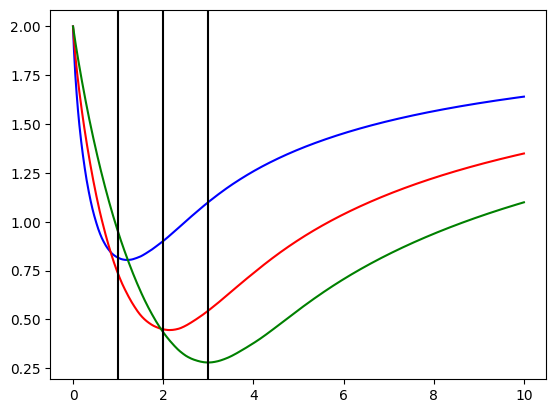

In [22]:
y_true_1 = pd.Series(np.random.normal(1, 1, 500))
y_true_2 = pd.Series(np.random.normal(2, 1, 500))
y_true_3 = pd.Series(np.random.normal(3, 1, 500))
y_pred = pd.Series(np.ones(500))

x = np.linspace(0,10,1000)

res_1 = list([smape(y_true_1, i * y_pred) for i in x])
res_2 = list([smape(y_true_2, i * y_pred) for i in x])
res_3 = list([smape(y_true_3, i * y_pred) for i in x])

plt.plot(x, res_1, color='b')
plt.plot(x, res_2, color='r')
plt.plot(x, res_3, color='g')

plt.axvline(x=1, color='k')
plt.axvline(x=2, color='k')
plt.axvline(x=3, color='k')

SMAPE가 낮은 지점 -> y값의 평균 지점

### Simple median model

가장 마지막 p개의 중앙값을 예측값으로 사용하는 모델

In [23]:
def plot_prediction_and_actual_2(train, forecast, actual, xlim=None, ylim=None, figsize=None, title=None):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.plot(pd.to_datetime(train.index), train.values, 'k.')
    ax.plot(pd.to_datetime(actual.index), actual.values, 'r.')
    ax.plot(pd.to_datetime(forecast.index), forecast.values, 'b-')
    ax.set_title(title)
    plt.show()

In [24]:
def median_model(df_train, df_actual, p, review=False, figsize=(12,4)):
    def nanmedian_zero(a):
        return np.nan_to_num(np.nanmedian(a))

    df_train['y'] = pd.to_numeric(df_train['y'], errors='coerce')
    df_actual['y'] = pd.to_numeric(df_actual['y'], errors='coerce')
    visits = nanmedian_zero(df_train['y'].values[-p:])
    train_series = df_train['y']
    train_series.index = df_train.ds

    idx = np.arange(p) + np.arange(len(df_train) - p + 1)[:, None]
    b = [row[row>=0] for row in df_train.y.values[idx]]
    pre_forecast = pd.Series(np.append(([float('nan')] * (p-1)), list(map(nanmedian_zero, b))))
    pre_forecast.index = df_train.ds

    forecast_series = pd.Series(np.repeat(visits, len(df_actual)))
    forecast_series.index = df_actual.ds
    
    forecast_series = pd.concat([pre_forecast, forecast_series])
    
    actual_series = df_actual.y
    actual_series.index = df_actual.ds
    
    if(review):
        plot_prediction_and_actual_2(train_series, forecast_series, actual_series, figsize=figsize, title='Median model')
    
    return smape(forecast_series, actual_series)
    

                                    Page  2015-07-01  2015-07-02  2015-07-03  \
2  3C_zh.wikipedia.org_all-access_spider         1.0         0.0         1.0   

   2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  2015-07-09  \
2         1.0         0.0         4.0         0.0         3.0         4.0   

   ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  2016-12-26  \
2  ...         3.0         1.0         1.0         7.0         4.0   

   2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
2         4.0         6.0         3.0         4.0        17.0  

[1 rows x 551 columns]


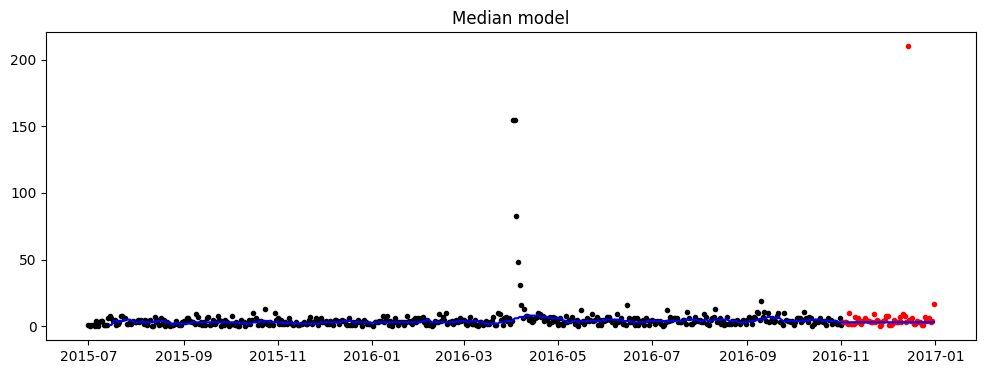

The SMAPE score is : 0.50096


In [25]:
print(train.iloc[[2]])

df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)
lang = X_train.iloc[2, 1]
score = median_model(df_train.copy(), df_actual.copy(), 15, review=True)
print("The SMAPE score is : %.5f" % score)

### median model - weekday, weekend and holiday

- 휴일과 비휴일을 구분하여 예측값 도출  
    - 휴일과 주말에 대해서는 휴일용 중앙값
    - 평일에는 비휴일용 중앙값

In [26]:
holiday_en_us = ['2015-01-01', '2015-01-19', '2015-05-25', '2015-07-03', '2015-09-07', '2015-11-26', '2015-11-27', '2015-12-25', '2016-01-01', '2016-01-18', '2016-05-30', '2016-07-04', '2016-09-05', '2016-11-11', '2016-11-24', '2016-12-26', '2017-01-01', '2017-01-02', '2017-01-16', '2017-05-29', '2017-07-04', '2017-09-04', '2017-11-10', '2017-11-23', '2017-12-25']
holiday_en_uk = ['2015-01-01', '2015-04-03', '2015-05-04', '2015-05-25', '2015-12-25', '2015-12-26', '2015-12-28', '2016-01-01', '2016-03-25', '2016-05-02', '2016-05-30', '2016-12-26', '2016-12-27', '2017-01-01', '2017-04-14', '2017-05-01', '2017-05-29', '2017-12-25', '2017-12-26']
holiday_en_canada = ['2015-01-01', '2015-07-01', '2015-09-07', '2015-12-25', '2016-01-01', '2016-07-01', '2016-09-05', '2016-12-25', '2017-01-01', '2017-07-01', '2017-07-03', '2017-09-04', '2017-12-25']

holiday_ru_russia = ['2015-01-01', '2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09', '2015-02-23', '2015-03-09', '2015-05-01', '2015-05-04', '2015-05-09', '2015-05-11', '2015-06-12', '2015-11-04', '2016-01-01', '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07', '2016-02-22', '2016-02-23', '2016-03-08', '2016-05-01', '2016-05-09', '2016-06-12', '2016-06-13', '2016-11-04', '2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-07', '2017-02-23', '2017-02-24', '2017-03-08', '2017-05-01', '2017-05-08', '2017-05-09', '2017-06-12', '2017-11-04', '2017-11-06']

holiday_es_mexico = ['2015-01-01', '2015-02-02', '2015-03-16', '2015-04-02', '2015-04-03', '2015-05-01', '2015-09-16', '2015-10-12', '2015-11-02', '2015-11-16', '2015-12-12', '2015-12-25', '2016-01-01', '2016-02-01', '2016-03-21', '2016-03-24', '2016-03-25', '2016-05-01', '2016-09-16', '2016-10-12', '2016-11-02', '2016-11-21', '2016-12-12', '2016-12-25', '2016-12-26', '2017-01-01', '2017-01-02', '2017-02-06', '2017-03-20', '2017-04-13', '2017-04-14', '2017-05-01', '2017-09-16', '2017-10-12', '2017-11-02', '2017-11-20', '2017-12-12', '2017-12-25']
holiday_es_spain = ['2017-01-01', '2017-01-06', '2017-04-14', '2017-05-01', '2017-08-15', '2017-10-12', '2017-11-01', '2017-12-06', '2017-12-08', '2017-12-25', '2016-01-01', '2016-01-06', '2016-03-25', '2016-05-01', '2016-08-15', '2016-10-12', '2016-11-01', '2016-12-06', '2016-12-08', '2016-12-25', '2015-01-01', '2015-01-06', '2015-04-03', '2015-05-01', '2015-10-12', '2015-11-01', '2015-12-06', '2015-12-08', '2015-12-25']
holiday_es_colombia = ['2015-01-01', '2015-01-12', '2015-03-23', '2015-04-02', '2015-04-03', '2015-05-01', '2015-05-18', '2015-06-08', '2015-06-15', '2015-06-29', '2015-07-20', '2015-08-07', '2015-08-17', '2015-10-12', '2015-11-02', '2015-11-16', '2015-12-08', '2015-12-25', '2016-01-01', '2016-01-11', '2016-03-21', '2016-03-24', '2016-03-25', '2016-05-01', '2016-05-09', '2016-05-30', '2016-06-06', '2016-07-04', '2016-07-20', '2016-08-07', '2016-08-15', '2016-10-17', '2016-11-07', '2016-11-14', '2016-12-08', '2016-12-25', '2017-01-01', '2017-01-09', '2017-03-20', '2017-04-13', '2017-04-14', '2017-05-01', '2017-05-29', '2017-06-19', '2017-06-26', '2017-07-03', '2017-07-20', '2017-08-07', '2017-08-15', '2017-10-16', '2017-11-06', '2017-11-13', '2017-12-08', '2017-12-25']

holiday_fr_france = ['2015-01-01', '2015-04-06', '2015-05-01', '2015-05-08', '2015-05-14', '2015-05-25', '2015-07-14', '2015-08-15', '2015-11-01', '2015-11-11', '2015-12-25', '2016-01-01', '2016-03-28', '2016-05-01', '2016-05-05', '2016-05-08', '2016-05-16', '2016-07-14', '2016-08-15', '2016-11-01', '2016-11-11', '2016-12-25', '2017-01-01', '2017-04-17', '2017-05-01', '2017-05-08', '2017-05-25', '2017-06-05', '2017-07-14', '2017-08-15', '2017-11-01', '2017-11-11', '2017-12-25']
holiday_jp_japan = ['2015-01-01', '2015-01-12', '2015-02-11', '2015-03-21', '2015-04-29', '2015-05-03', '2015-05-04', '2015-05-05', '2015-05-06', '2015-07-20', '2015-09-21', '2015-09-22', '2015-09-23', '2015-10-12', '2015-11-03', '2015-11-23', '2015-12-23', '2016-01-01', '2016-01-11', '2016-02-11', '2016-03-21', '2016-04-29', '2016-05-03', '2016-05-04', '2016-05-05', '2016-07-18', '2016-08-11', '2016-09-19', '2016-09-22', '2016-10-10', '2016-11-03', '2016-11-23', '2016-12-23', '2017-01-01', '2017-01-09', '2017-02-11', '2017-03-20', '2017-04-29', '2017-05-03', '2017-05-04', '2017-05-05', '2017-07-17', '2017-08-11', '2017-09-18', '2017-09-22', '2017-10-09', '2017-11-03', '2017-11-23', '2017-12-23']

holiday_de_germany = ['2015-01-01', '2015-04-03', '2015-04-06', '2015-05-01', '2015-05-14', '2015-05-14', '2015-05-25', '2015-10-03', '2015-12-25', '2015-12-26', '2016-01-01', '2016-03-25', '2016-03-28', '2016-05-01', '2016-05-05', '2016-05-16', '2016-10-03', '2016-12-25', '2016-12-26', '2017-01-01', '2017-04-14', '2017-04-17', '2017-05-01', '2017-05-25', '2017-06-05', '2017-10-03', '2017-10-31', '2017-12-25', '2017-12-26']
holiday_de_austria = ['2015-01-01', '2015-01-06', '2015-04-06', '2015-05-01', '2015-05-14', '2015-05-25', '2015-06-04', '2015-08-15', '2015-10-26', '2015-11-01', '2015-12-08', '2015-12-25', '2015-12-26', '2016-01-01', '2016-01-06', '2016-03-28', '2016-05-01', '2016-05-05', '2016-05-16', '2016-05-26', '2016-08-15', '2016-10-26', '2016-11-01', '2016-12-08', '2016-12-25', '2016-12-26', '2017-01-01', '2017-01-06', '2017-04-17', '2017-05-01', '2017-05-25', '2017-06-05', '2017-06-15', '2017-08-15', '2017-10-26', '2017-11-01', '2017-12-08', '2017-12-25', '2017-12-26']
holiday_de_switzerland = ['2015-01-01', '2015-04-03', '2015-05-14', '2015-08-01', '2015-12-25', '2016-01-01', '2016-03-25', '2016-05-05', '2016-08-01', '2016-12-25', '2017-01-01', '2017-04-14', '2017-05-25', '2017-08-01', '2017-12-25']

holiday_zh_hongkong = ['2015-01-01', '2015-02-19', '2015-02-20', '2015-04-03', '2015-04-04', '2015-04-05', '2015-04-06', '2015-04-07', '2015-05-01', '2015-05-25', '2015-06-20', '2015-07-01', '2015-09-03', '2015-09-28', '2015-10-01', '2015-10-21', '2015-12-25', '2015-12-26', '2016-01-01', '2016-02-08', '2016-02-09', '2016-02-10', '2016-03-25', '2016-03-26', '2016-03-28', '2016-04-04', '2016-05-01', '2016-05-02', '2016-05-14', '2016-06-09', '2016-07-01', '2016-09-16', '2016-10-01', '2016-10-10', '2016-12-25', '2016-12-26', '2016-12-27', '2017-01-01', '2017-01-02', '2017-01-28', '2017-01-30', '2017-01-31', '2017-04-04', '2017-04-14', '2017-04-15', '2017-04-17', '2017-05-01', '2017-05-03', '2017-05-30', '2017-07-01', '2017-10-01', '2017-10-02', '2017-10-05', '2017-10-28', '2017-12-25', '2017-12-26']
holiday_zh_taiwan = ['2015-01-01', '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23', '2015-02-23', '2015-02-27', '2015-04-03', '2015-04-05', '2015-04-06', '2015-06-19', '2015-06-20', '2015-09-28', '2015-10-09', '2015-10-10', '2016-01-01', '2016-02-07', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-29', '2016-04-04', '2016-04-05', '2016-06-09', '2016-06-10', '2016-09-15', '2016-09-16', '2016-09-28', '2016-10-10', '2017-01-01', '2017-01-02', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-27', '2017-02-28', '2017-04-03', '2017-04-04', '2017-05-01', '2017-05-29', '2017-05-30', '2017-10-04', '2017-10-09', '2017-10-10']

holidays_en_us = pd.DataFrame({
  'holiday': 'US public holiday',
  'ds': pd.to_datetime(holiday_en_us),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_en_uk = pd.DataFrame({
  'holiday': 'UK public holiday',
  'ds': pd.to_datetime(holiday_en_uk),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_en_canada = pd.DataFrame({
  'holiday': 'Canada public holiday',
  'ds': pd.to_datetime(holiday_en_canada),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_en = pd.concat((holidays_en_us, holidays_en_uk, holidays_en_canada))

holidays_ru_russia = pd.DataFrame({
  'holiday': 'Russia public holiday',
  'ds': pd.to_datetime(holiday_ru_russia),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_ru = holidays_ru_russia

holidays_es_mexico = pd.DataFrame({
  'holiday': 'Mexico public holiday',
  'ds': pd.to_datetime(holiday_es_mexico),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_es_spain = pd.DataFrame({
  'holiday': 'Spain public holiday',
  'ds': pd.to_datetime(holiday_es_spain),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_es_colombia = pd.DataFrame({
  'holiday': 'Colombia public holiday',
  'ds': pd.to_datetime(holiday_es_colombia),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_es = pd.concat((holidays_es_mexico, holidays_es_spain, holidays_es_colombia))

holidays_fr_france = pd.DataFrame({
  'holiday': 'France public holiday',
  'ds': pd.to_datetime(holiday_fr_france),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_fr = holidays_fr_france

holidays_jp_japan = pd.DataFrame({
  'holiday': 'Japan public holiday',
  'ds': pd.to_datetime(holiday_jp_japan),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_jp = holidays_jp_japan

holidays_de_germany = pd.DataFrame({
  'holiday': 'Germany public holiday',
  'ds': pd.to_datetime(holiday_de_germany),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_de_austria = pd.DataFrame({
  'holiday': 'Austria public holiday',
  'ds': pd.to_datetime(holiday_de_austria),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_de_switzerland = pd.DataFrame({
  'holiday': 'Switzerland public holiday',
  'ds': pd.to_datetime(holiday_de_switzerland),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_de = pd.concat((holidays_de_germany, holidays_de_austria, holidays_de_switzerland))

holidays_zh_hongkong = pd.DataFrame({
  'holiday': 'HK public holiday',
  'ds': pd.to_datetime(holiday_zh_hongkong),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_zh_taiwan = pd.DataFrame({
  'holiday': 'Taiwan public holiday',
  'ds': pd.to_datetime(holiday_zh_taiwan),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_zh = pd.concat((holidays_zh_hongkong, holidays_zh_taiwan))

holidays_dict = {"en": holidays_en, 
                 "ru": holidays_ru, 
                 "es": holidays_es, 
                 "fr": holidays_fr, 
                 "ja": holidays_jp,
                 "de": holidays_de,
                 "zh": holidays_zh}

In [27]:
def median_holiday_model(df_train, df_actual, p, lang, review=False, figsize=(12, 4)):
    # Split the train and actual set
    
        
    df_train['ds'] = pd.to_datetime(df_train['ds'])
    df_actual['ds'] = pd.to_datetime(df_actual['ds'])
    train_series = df_train['y']
    train_series.index = df_train.ds
    
    if(isinstance(lang, float) and math.isnan(lang)):
        df_train['holiday'] = df_train.ds.dt.dayofweek >=5  # lang(국가)이 주어지지 않은 경우 주말만 공휴일로 계산
        df_actual['holiday'] = df_actual.ds.dt.dayofweek >=5
    # lang(국가)이 주어진 경우 공휴일과 주말 모두 공휴일로 계산
    else:
        df_train['holiday'] = (df_train.ds.dt.dayofweek >=5) | df_train.ds.isin(holidays_dict[lang].ds)
        df_actual['holiday'] = (df_actual.ds.dt.dayofweek >=5) | df_actual.ds.isin(holidays_dict[lang].ds)

    # Combine the train and actual set
    predict_holiday = median_holiday_helper(df_train, df_actual[df_actual.holiday], p, True)
    predict_non_holiday = median_holiday_helper(df_train, df_actual[~df_actual.holiday], p, False)

    forecast_series = predict_non_holiday.combine_first(predict_holiday)  
    # 휴일과 비휴일의 예측값을 합쳐서 최종 예측값으로 만듦 / 비휴일 예측 우선 적용, 해당 날짜가 없다면 휴일 예측 사용

    
    actual_series = df_actual.y
    actual_series.index = df_actual.ds
    
    if(review):
        plot_prediction_and_actual_2(train_series, forecast_series, actual_series, figsize=figsize, title='Median model with holiday')
    
    return smape(forecast_series, actual_series)


def median_holiday_helper(df_train, df_actual, p, holiday):
    def nanmedian_zero(a):
        return np.nan_to_num(np.nanmedian(a))
    
    df_train['y'] = pd.to_numeric(df_train['y'])
    df_actual['y'] = pd.to_numeric(df_actual['y'])
    
    sample = df_train[-p:]
    if(holiday):
        sample = sample[sample['holiday']]
    else:
        sample = sample[~sample['holiday']]

    visits = nanmedian_zero(sample['y'])
    
    idx = np.arange( p) + np.arange(len(df_train)- p+1)[:,None]
    b = [row[row>=0] for row in df_train.y.values[idx]]
    pre_forecast = pd.Series(np.append(([float('nan')] * (p-1)), list(map(nanmedian_zero,b))))
    pre_forecast.index = df_train.ds

    forecast_series = pd.Series(np.repeat(visits, len(df_actual)))
    forecast_series.index = df_actual.ds
    
    forecast_series = pd.concat([pre_forecast, forecast_series])
    
    return forecast_series

                                    Page  2015-07-01  2015-07-02  2015-07-03  \
2  3C_zh.wikipedia.org_all-access_spider         1.0         0.0         1.0   

   2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  2015-07-09  \
2         1.0         0.0         4.0         0.0         3.0         4.0   

   ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  2016-12-26  \
2  ...         3.0         1.0         1.0         7.0         4.0   

   2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
2         4.0         6.0         3.0         4.0        17.0  

[1 rows x 551 columns]


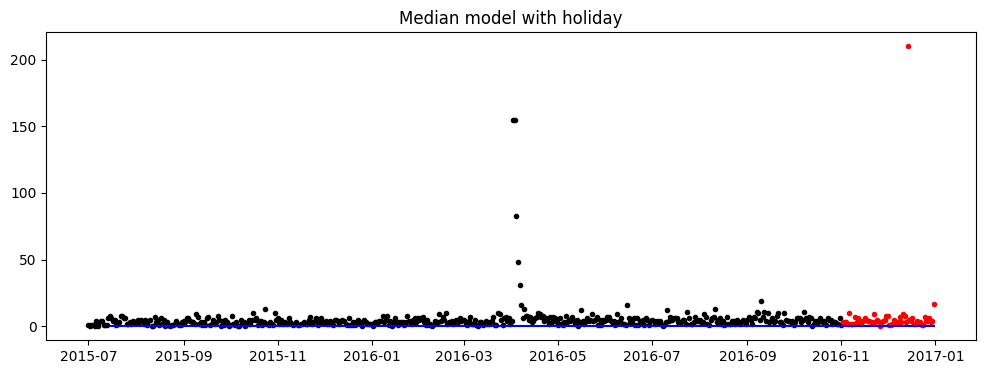

The SMAPE score is : 1.96667


In [28]:
# This is to demo the median model - weekday, weekend and 
print(train.iloc[[2]])

df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)
lang = X_train.iloc[2, 1]
score = median_holiday_model(df_train.copy(), df_actual.copy(), 15, lang, review=True)
print("The SMAPE score is : %.5f" % score)

### ARIMA model

AR -> autoregressive / 과거 시점의 자기 자신의 데이터가 현 시점의 자기 자신에게 영향  
MA -> moving average / 이전 항에서의 error텀을 현 시점에 반영. 변화율(추세)에 맞춰 추정하겠다는 뜻

In [29]:
from statsmodels.tsa.arima.model import ARIMA 
import warnings

def arima_model(df_train, df_actual, p, d, q, figsize=(12, 4), review=False):
    df_train = df_train.fillna(0)
    train_series = df_train.y
    train_series.index = df_train.ds

    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(train_series, order=(p, d, q))
            result = arima.fit()
        except Exception as e:
            print('\tARIMA failed', e)
                
    #print(result.params)
    start_idx = df_train.ds[d]
    end_idx = df_actual.ds.max()
    forecast_series = result.predict(start_idx, end_idx,typ='levels')
    
    actual_series = df_actual.y
    actual_series.index = pd.to_datetime(df_actual.ds)

    if(review):
        plot_prediction_and_actual_2(train_series, forecast_series, actual_series, figsize=figsize, title='ARIMA model')
    
    return smape(forecast_series, actual_series)

                                    Page  2015-07-01  2015-07-02  2015-07-03  \
2  3C_zh.wikipedia.org_all-access_spider         1.0         0.0         1.0   

   2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  2015-07-09  \
2         1.0         0.0         4.0         0.0         3.0         4.0   

   ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  2016-12-26  \
2  ...         3.0         1.0         1.0         7.0         4.0   

   2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
2         4.0         6.0         3.0         4.0        17.0  

[1 rows x 551 columns]


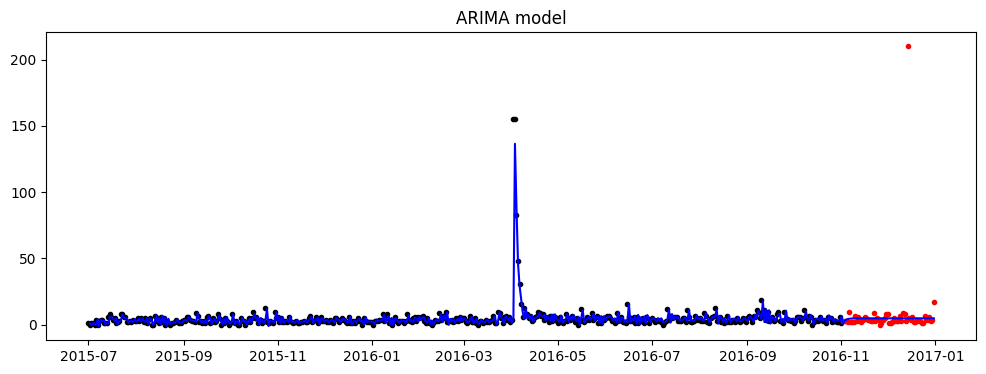

The SMAPE score is : 0.54808


In [30]:
# This is to demo the ARIMA model
print(train.iloc[[2]])

df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)
lang = X_train.iloc[2, 1]
score = arima_model(df_train.copy(), df_actual.copy(), 2, 1, 2, review=True)
print("The SMAPE score is : %.5f" % score)

### facebook prophet library

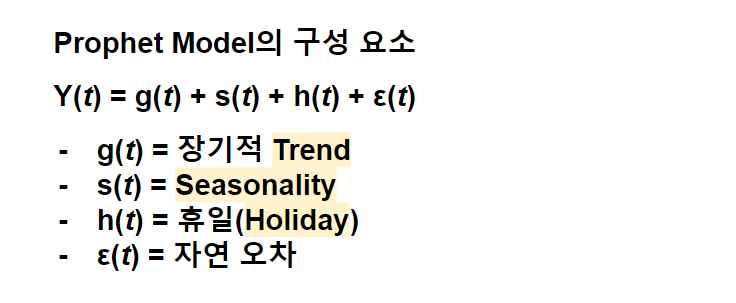
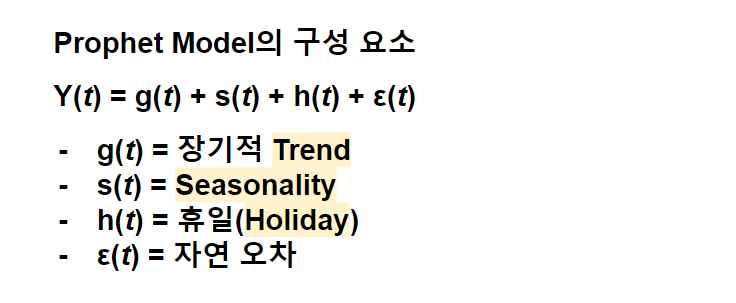

In [31]:
def plot_prediction_and_actual(model, forecast, actual, xlim=None, ylim=None, figsize=None, title=None):
    fig, ax  = plt.subplots(1,1,figsize=figsize)
    ax.set_ylim(ylim)
    ax.plot(pd.to_datetime(actual.ds), actual.y, 'r.')
    model.plot(forecast, ax=ax);
    ax.set_title(title)
    plt.show()

In [45]:
# simple linear model
def normal_model(df_train, df_actual, review=False):
    start_date = df_actual.ds.min()
    end_date = df_actual.ds.max()
    
    actual_series = df_actual.y.copy()
    actual_series.index = df_actual.ds

    df_train['y'] = df_train['y'].astype('float')
    
    df_actual['y'] = df_actual['y'].astype('float')
    
    m = Prophet()
    m.fit(df_train)
    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)
        
    if(review):
        ymin = min(df_actual.y.min(), df_train.y.min()) -100
        ymax = max(df_actual.y.max(), df_train.y.max()) +100
        #
        plot_prediction_and_actual(m, forecast, df_actual, ylim=[ymin, ymax], figsize=(12,4), title='Normal model')

    mask = (forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)
    forecast_series = forecast[mask].yhat
    forecast_series.index = forecast[mask].ds
    forecast_series[forecast_series < 0] = 0

    return smape(forecast_series, actual_series)


def holiday_model(df_train, df_actual, lang, review=False):
    start_date = df_actual.ds.min()
    end_date = df_actual.ds.max()
    
    actual_series = df_actual.y.copy()
    actual_series.index = df_actual.ds

    df_train['y'] = df_train['y'].astype('float')
    
    df_actual['y'] = df_actual['y'].astype('float')

    if(isinstance(lang, float) and math.isnan(lang)):
        holidays = None
    else:
        holidays = holidays_dict[lang]

    m = Prophet(holidays=holidays)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)

    if(review):
        ymin = min(df_actual.y.min(), df_train.y.min()) -100
        ymax = max(df_actual.y.max(), df_train.y.max()) +100
        plot_prediction_and_actual(m, forecast, df_actual, ylim=[ymin, ymax], figsize=(12,4), title='Holiday model')
    
    mask = (forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)
    forecast_series = forecast[mask].yhat
    forecast_series.index = forecast[mask].ds
    forecast_series[forecast_series < 0] = 0

    return smape(forecast_series, actual_series)


def yearly_model(df_train, df_actual, lang, review=False):
    start_date = df_actual.ds.min()
    end_date = df_actual.ds.max()
    
    actual_series = df_actual.y.copy()
    actual_series.index = df_actual.ds

    df_train['y'] = df_train['y'].astype('float')
    
    df_actual['y'] = df_actual['y'].astype('float')

    if(isinstance(lang, float) and math.isnan(lang)):
        holidays = None
    else:
        holidays = holidays_dict[lang]

    m = Prophet(holidays=holidays, yearly_seasonality=True)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)

    if(review):
        ymin = min(df_actual.y.min(), df_train.y.min()) -100
        ymax = max(df_actual.y.max(), df_train.y.max()) +100
        plot_prediction_and_actual(m, forecast, df_actual, ylim=[ymin, ymax], figsize=(12,4), title='Yealry model')
    
    mask = (forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)
    forecast_series = forecast[mask].yhat
    forecast_series.index = forecast[mask].ds
    forecast_series[forecast_series < 0] = 0

    return smape(forecast_series, actual_series)

- 로그변환한 모델
    - 0값 처리와 수렴 안정성을 위해 log 대신 log1p 사용
    - 로그 변환은 시계열의 변동성을 줄이고 추세 추정에 유리

In [46]:
# log model
def normal_model_log(df_train, df_actual, review=False):
    start_date = df_actual.ds.min()
    end_date = df_actual.ds.max()
    
    actual_series = df_actual.y.copy()
    actual_series.index = df_actual.ds

    df_train['y'] = df_train['y'].astype('float')
    df_train.y = np.log1p(df_train.y)
    
    df_actual['y'] = df_actual['y'].astype('float')
    df_actual.y = np.log1p(df_actual.y)
    
    m = Prophet()
    m.fit(df_train)
    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)
    
    if(review):
        ymin = min(df_actual.y.min(), df_train.y.min()) -2
        ymax = max(df_actual.y.max(), df_train.y.max()) +2
        plot_prediction_and_actual(m, forecast, df_actual, ylim=[ymin, ymax], figsize=(12,4), title='Normal model in log')

    mask = (forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)
    forecast_series = np.expm1(forecast[mask].yhat)
    forecast_series.index = forecast[mask].ds
    forecast_series[forecast_series < 0] = 0

    return smape(forecast_series, actual_series)


def holiday_model_log(df_train, df_actual, lang, review=False):
    start_date = df_actual.ds.min()
    end_date = df_actual.ds.max()
    
    actual_series = df_actual.y.copy()
    actual_series.index = df_actual.ds

    df_train['y'] = df_train['y'].astype('float')
    df_train.y = np.log1p(df_train.y)
    
    df_actual['y'] = df_actual['y'].astype('float')
    df_actual.y = np.log1p(df_actual.y)

    if(isinstance(lang, float) and math.isnan(lang)):
        holidays = None
    else:
        holidays = holidays_dict[lang]
    m = Prophet(holidays=holidays)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)

    if(review):
        ymin = min(df_actual.y.min(), df_train.y.min()) -2
        ymax = max(df_actual.y.max(), df_train.y.max()) +2
        plot_prediction_and_actual(m, forecast, df_actual, ylim=[ymin, ymax], figsize=(12,4), title='Holiday model in log')
        
    mask = (forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)
    forecast_series = np.expm1(forecast[mask].yhat)
    forecast_series.index = forecast[mask].ds
    forecast_series[forecast_series < 0] = 0
    
    return smape(forecast_series, actual_series)

def yearly_model_log(df_train, df_actual, lang, review=False):
    start_date = df_actual.ds.min()
    end_date = df_actual.ds.max()
    
    actual_series = df_actual.y.copy()
    actual_series.index = df_actual.ds

    df_train['y'] = df_train['y'].astype('float')
    df_train.y = np.log1p(df_train.y)
    
    df_actual['y'] = df_actual['y'].astype('float')
    df_actual.y = np.log1p(df_actual.y)

    if(isinstance(lang, float) and math.isnan(lang)):
        holidays = None
    else:
        holidays = holidays_dict[lang]
        
    m = Prophet(holidays=holidays, yearly_seasonality=True)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)

    if(review):
        ymin = min(df_actual.y.min(), df_train.y.min()) -2
        ymax = max(df_actual.y.max(), df_train.y.max()) +2
        plot_prediction_and_actual(m, forecast, df_actual, ylim=[ymin, ymax], figsize=(12,4), title='Yearly model in log')
        
    mask = (forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)
    forecast_series = np.expm1(forecast[mask].yhat)
    forecast_series.index = forecast[mask].ds
    forecast_series[forecast_series < 0] = 0
    
    return smape(forecast_series, actual_series)

02:35:06 - cmdstanpy - INFO - Chain [1] start processing
02:35:06 - cmdstanpy - INFO - Chain [1] done processing


                                    Page  2015-07-01  2015-07-02  2015-07-03  \
2  3C_zh.wikipedia.org_all-access_spider         1.0         0.0         1.0   

   2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  2015-07-09  \
2         1.0         0.0         4.0         0.0         3.0         4.0   

   ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  2016-12-26  \
2  ...         3.0         1.0         1.0         7.0         4.0   

   2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
2         4.0         6.0         3.0         4.0        17.0  

[1 rows x 551 columns]


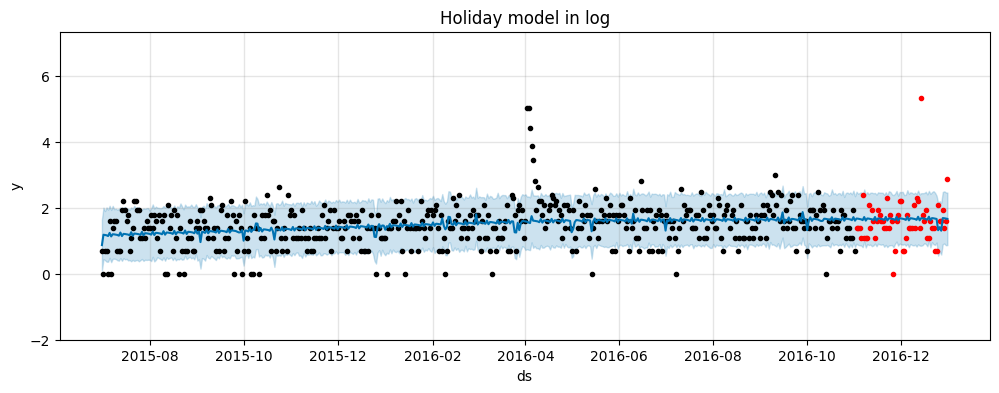

The SMAPE score is : 0.00000


In [47]:
# This is to demo the facebook prophet model
print(train.iloc[[2]])

df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)
lang = X_train.iloc[2, 1]
score = holiday_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

### Sample series analysis

#### case 1. SMAPE evaluation near zero and SMAPE score is too big

02:20:47 - cmdstanpy - INFO - Chain [1] start processing
02:20:47 - cmdstanpy - INFO - Chain [1] done processing


                                    Page  2015-07-01  2015-07-02  2015-07-03  \
2  3C_zh.wikipedia.org_all-access_spider         1.0         0.0         1.0   

   2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  2015-07-09  \
2         1.0         0.0         4.0         0.0         3.0         4.0   

   ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  2016-12-26  \
2  ...         3.0         1.0         1.0         7.0         4.0   

   2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
2         4.0         6.0         3.0         4.0        17.0  

[1 rows x 551 columns]


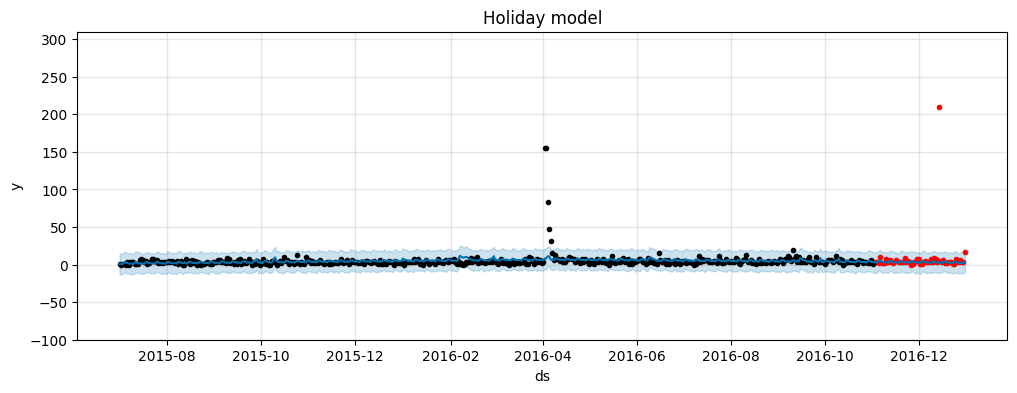

The SMAPE score is : 0.00000


In [35]:
print(train.iloc[[2]])

df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)
lang = X_train.iloc[2, 1]
score = holiday_model(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

#### case 2. Yearly model is the best model

02:20:48 - cmdstanpy - INFO - Chain [1] start processing
02:20:48 - cmdstanpy - INFO - Chain [1] done processing


                                             Page  2015-07-01  2015-07-02  \
4464  Automne_fr.wikipedia.org_desktop_all-agents       188.0       177.0   

      2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
4464       142.0       107.0       107.0       167.0       170.0       205.0   

      2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
4464       170.0  ...       102.0        81.0        74.0        75.0   

      2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
4464       129.0       120.0       106.0       122.0       106.0        84.0  

[1 rows x 551 columns]


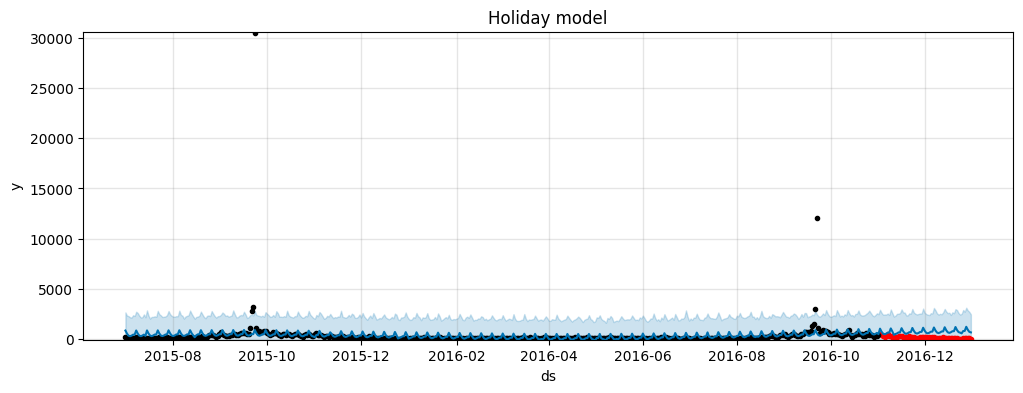

02:20:48 - cmdstanpy - INFO - Chain [1] start processing
02:20:48 - cmdstanpy - INFO - Chain [1] done processing


The SMAPE score is : 0.00000


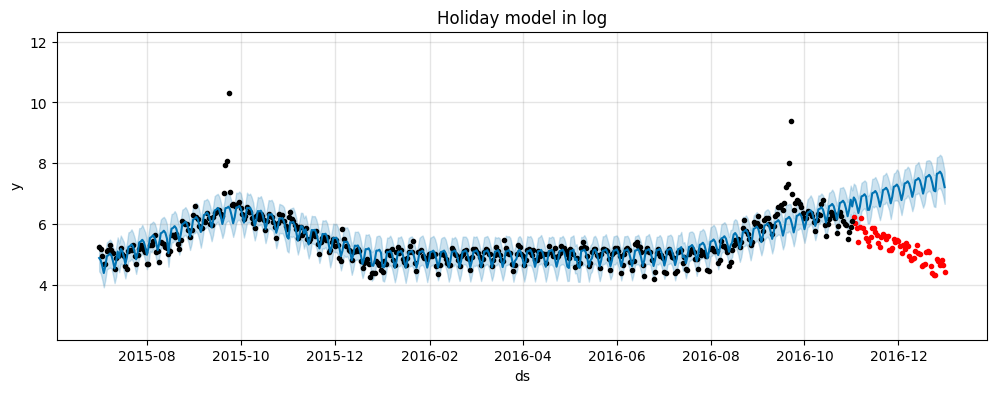

02:20:49 - cmdstanpy - INFO - Chain [1] start processing
02:20:49 - cmdstanpy - INFO - Chain [1] done processing


The SMAPE score is : 0.00000


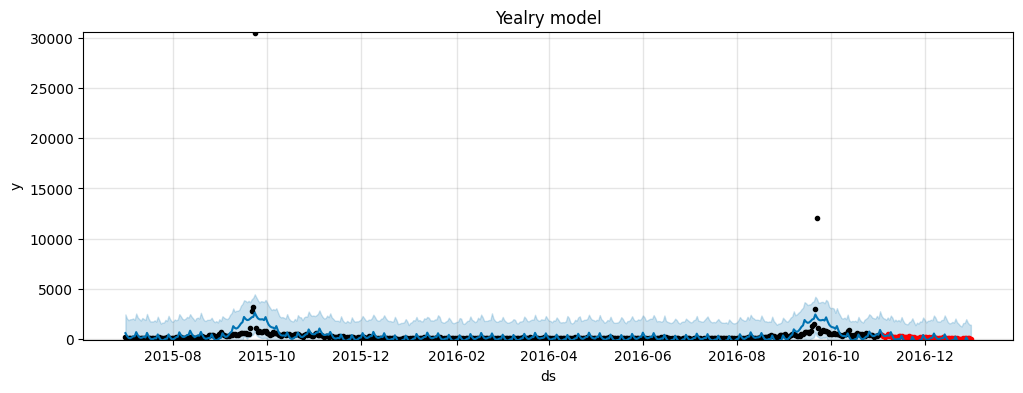

02:20:49 - cmdstanpy - INFO - Chain [1] start processing
02:20:49 - cmdstanpy - INFO - Chain [1] done processing


The SMAPE score is : 0.00000


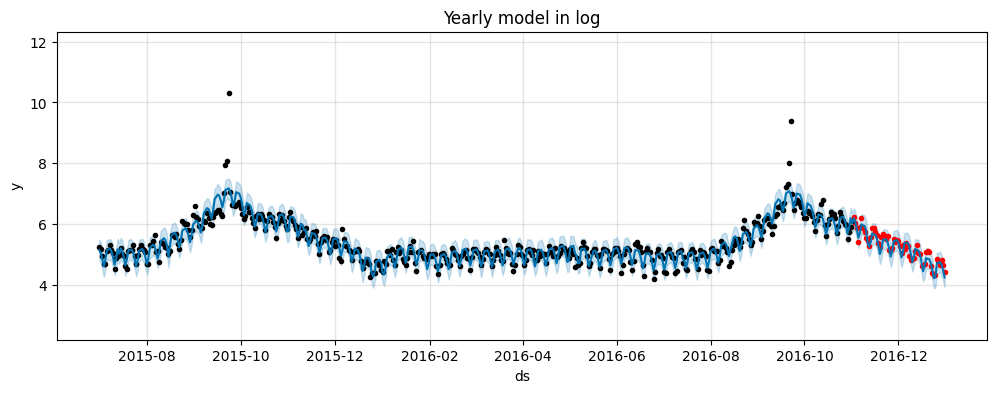

The SMAPE score is : 0.00000


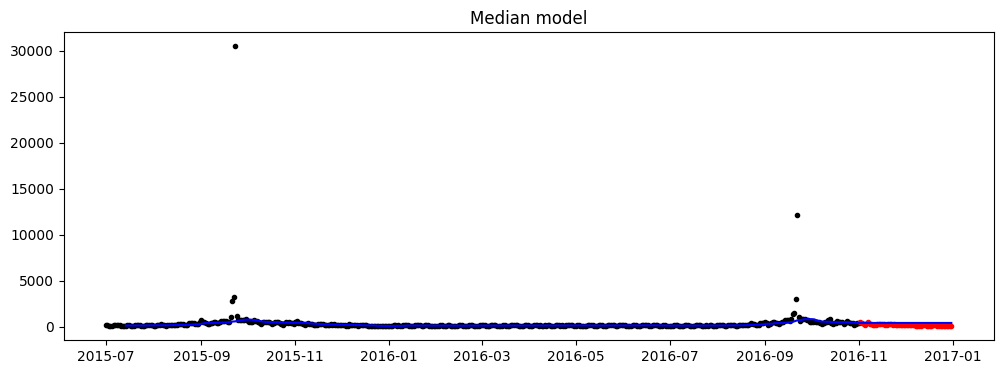

The SMAPE score is : 0.74763


In [36]:
print(train.iloc[[4464]])

df_train = extract_series(X_train, 4464, 5)
df_actual = extract_series(y_train, 4464, 5)
lang = X_train.iloc[4464, 1]

score = holiday_model(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = holiday_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = yearly_model(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = yearly_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = median_model(df_train.copy(), df_actual.copy(), 14, review=True)
print("The SMAPE score is : %.5f" % score)

#### case 3. Non-yearly model is better

02:20:50 - cmdstanpy - INFO - Chain [1] start processing
02:20:50 - cmdstanpy - INFO - Chain [1] done processing


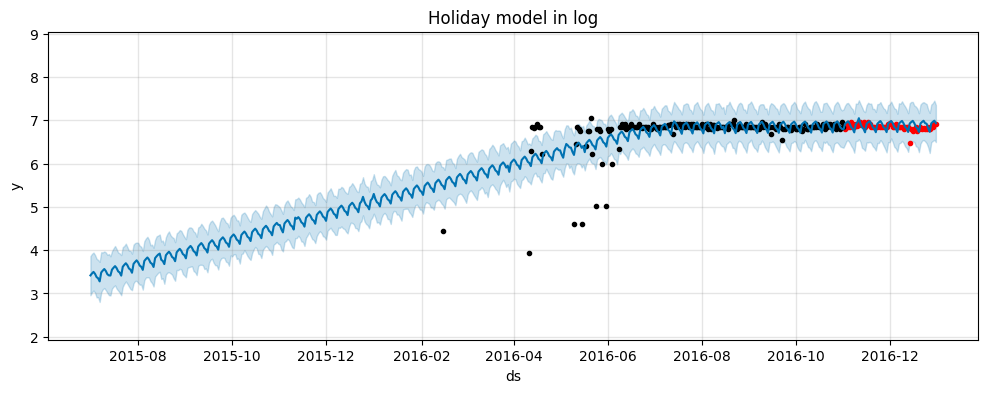

02:20:50 - cmdstanpy - INFO - Chain [1] start processing
02:20:50 - cmdstanpy - INFO - Chain [1] done processing


The SMAPE score is : 0.00000


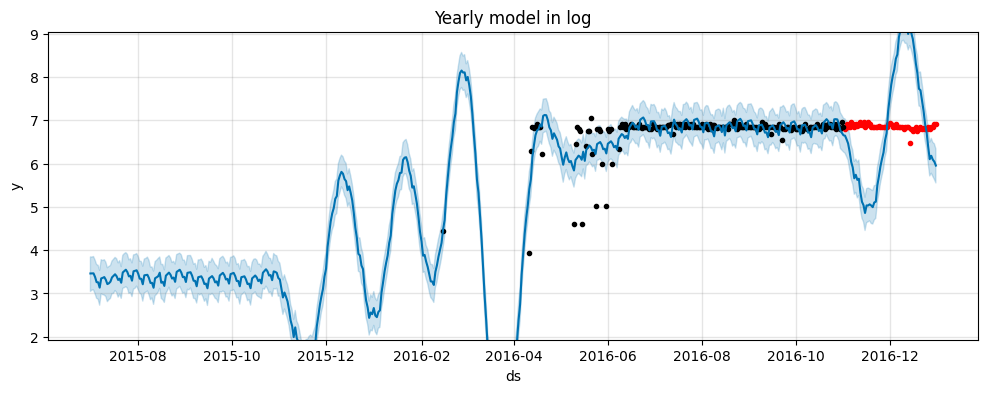

The SMAPE score is : 0.00000


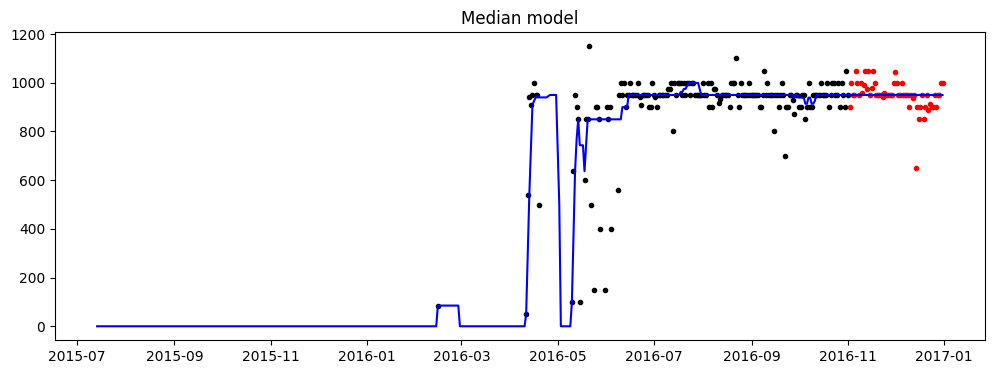

The SMAPE score is : 0.03718


In [37]:
train.iloc[[6245]]

df_train = extract_series(X_train, 6245, 5)
df_actual = extract_series(y_train, 6245, 5)
lang = X_train.iloc[6245, 1]
score = holiday_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = yearly_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = median_model(df_train.copy(), df_actual.copy(), 14, review=True)
print("The SMAPE score is : %.5f" % score)

#### case 4. SMAPE score is too high for all proposed models

02:20:51 - cmdstanpy - INFO - Chain [1] start processing
02:20:51 - cmdstanpy - INFO - Chain [1] done processing


File:Macaca_nigra_self-portrait_(rotated_and_cropped).jpg_commons.wikimedia.org_mobile-web_all-agents


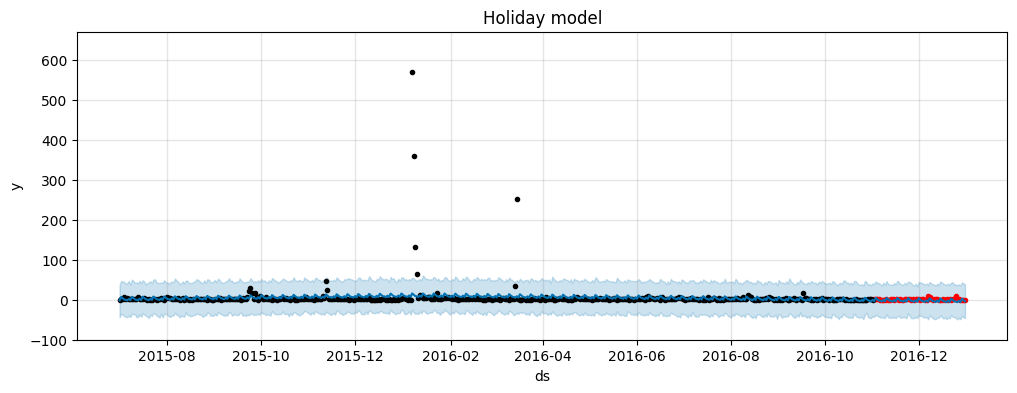

02:20:51 - cmdstanpy - INFO - Chain [1] start processing
02:20:51 - cmdstanpy - INFO - Chain [1] done processing


The SMAPE score is : 0.00000


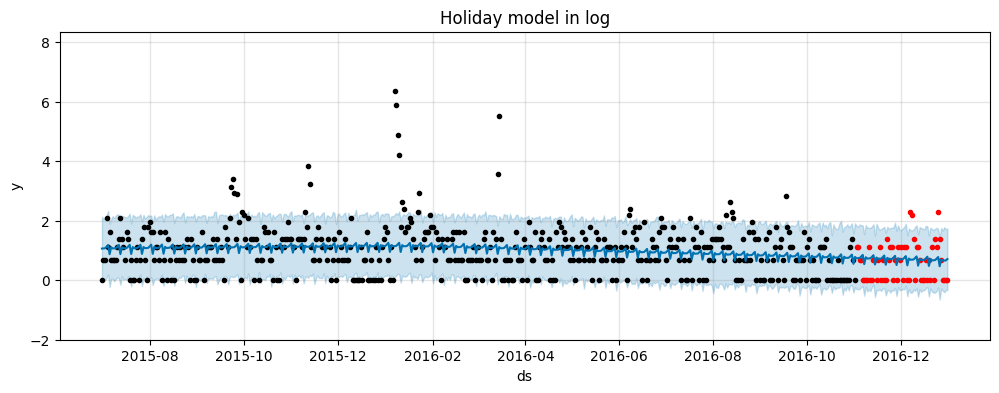

02:20:52 - cmdstanpy - INFO - Chain [1] start processing
02:20:52 - cmdstanpy - INFO - Chain [1] done processing


The SMAPE score is : 0.00000


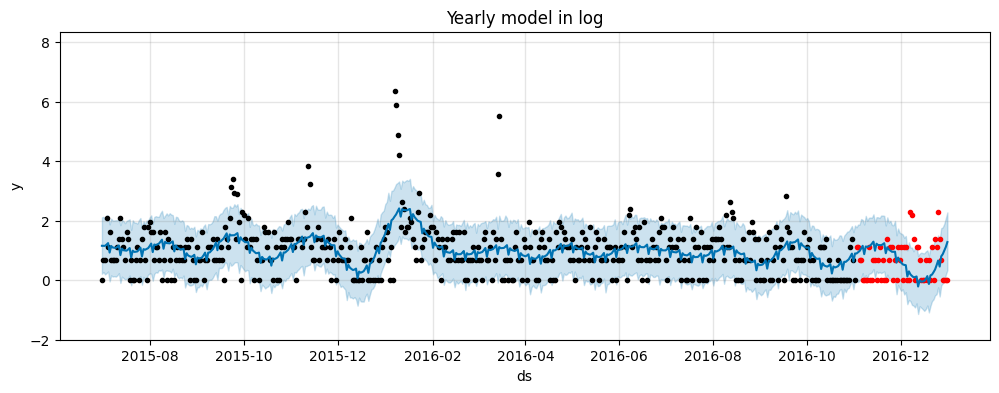

The SMAPE score is : 0.00000


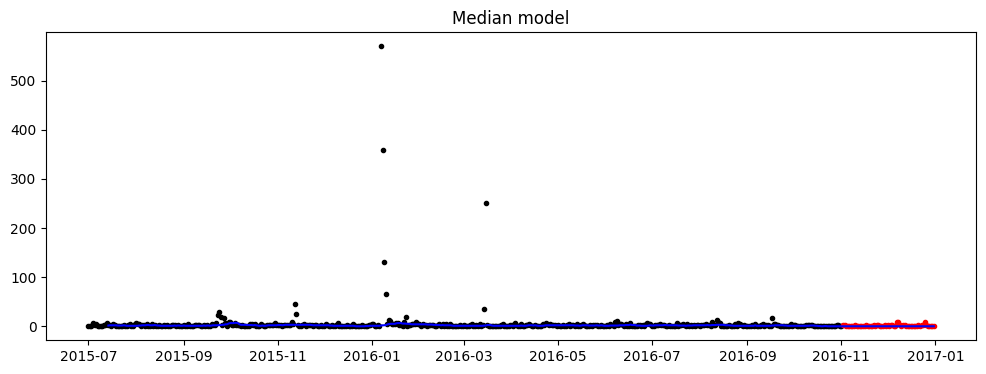

The SMAPE score is : 1.13333


In [38]:
train.iloc[[80002]]

df_train = extract_series(X_train, 80002, 5)
df_actual = extract_series(y_train, 80002, 5)
lang = X_train.iloc[80002, 1]
title = X_train.iloc[80002, 4]
print(title)

score = holiday_model(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = holiday_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = yearly_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

# Please use this case to check your implementation of SMAPE
score = median_model(df_train.copy(), df_actual.copy(), 14, review=True)
print("The SMAPE score is : %.5f" % score)

#### case 5. SMAPE score is too high for all proposed models

02:20:53 - cmdstanpy - INFO - Chain [1] start processing
02:20:53 - cmdstanpy - INFO - Chain [1] done processing


File:Memphis_Blues_Tour_2010.jpg_commons.wikimedia.org_mobile-web_all-agents


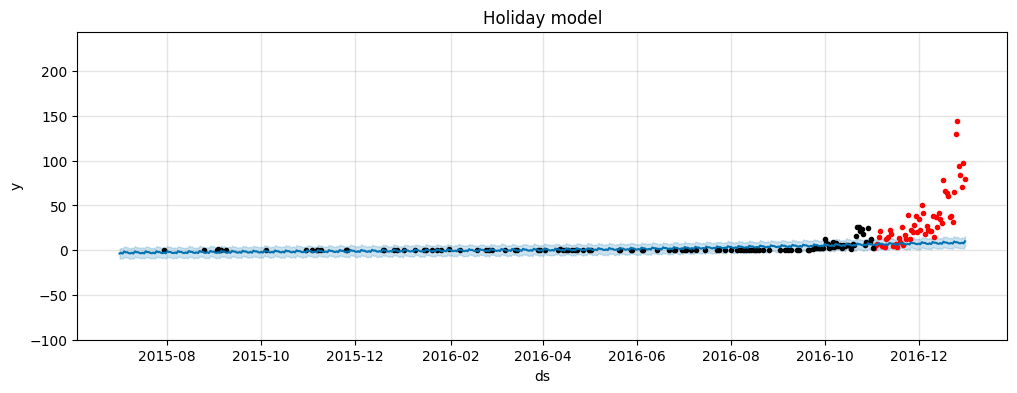

02:20:53 - cmdstanpy - INFO - Chain [1] start processing
02:20:53 - cmdstanpy - INFO - Chain [1] done processing


The SMAPE score is : 0.00000


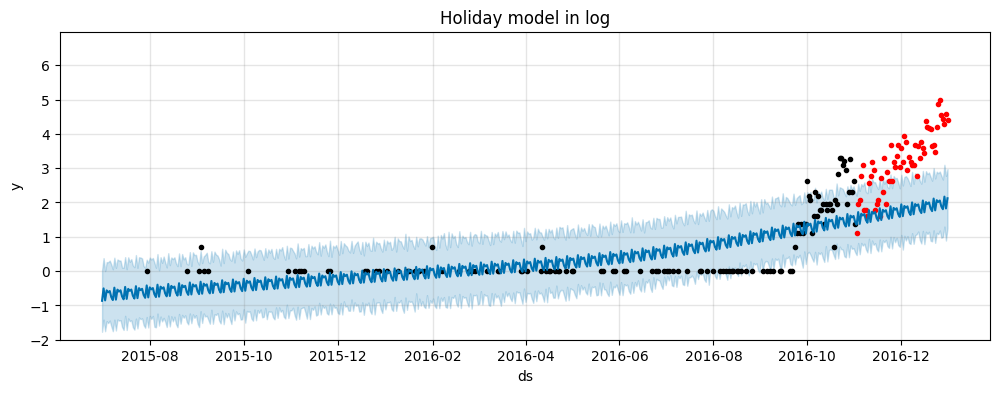

02:20:54 - cmdstanpy - INFO - Chain [1] start processing
02:20:54 - cmdstanpy - INFO - Chain [1] done processing


The SMAPE score is : 0.00000


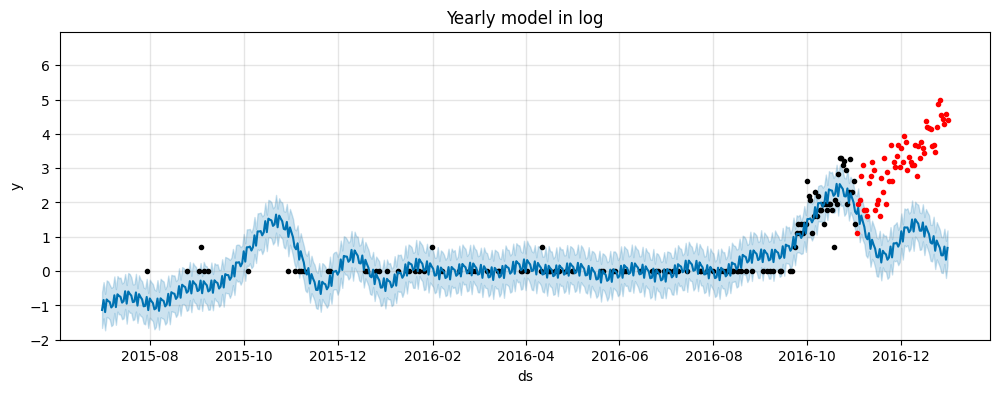

The SMAPE score is : 0.00000


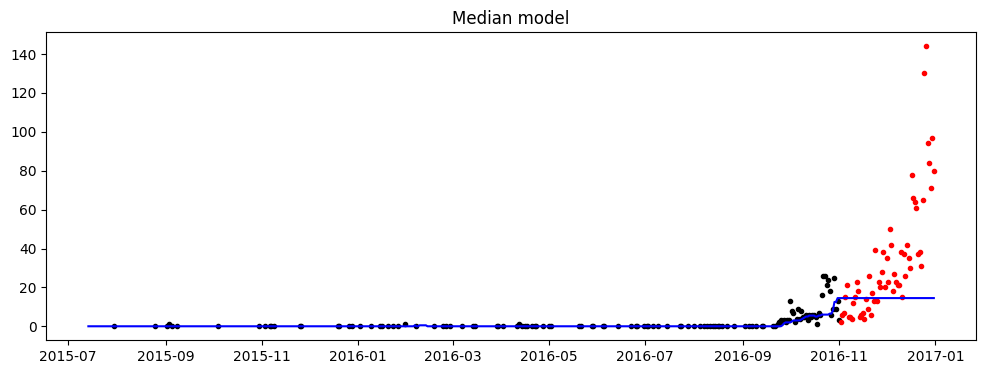

The SMAPE score is : 0.77174


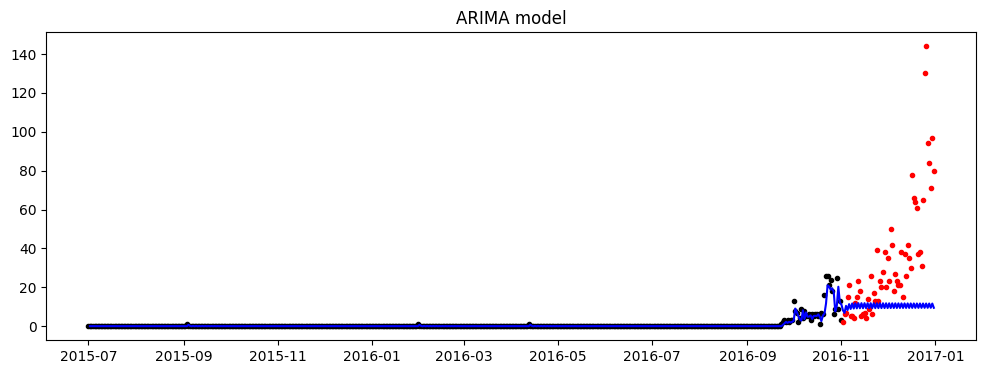

The SMAPE score is : 0.88524


In [39]:
train.iloc[[80009]]

df_train = extract_series(X_train, 80009, 5)
df_actual = extract_series(y_train, 80009, 5)
lang = X_train.iloc[80009, 1]
title = X_train.iloc[80009, 4]
print(title)

score = holiday_model(df_train.copy(), df_actual.copy(), review=True,lang=lang)
print("The SMAPE score is : %.5f" % score)

score = holiday_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = yearly_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = median_model(df_train.copy(), df_actual.copy(), 14, review=True)
print("The SMAPE score is : %.5f" % score)

score = arima_model(df_train.copy(), df_actual.copy(), 2, 1, 2, review=True)
print("The SMAPE score is : %.5f" % score)

#### case 6. SMAPE score is too high for all proposed models

02:20:55 - cmdstanpy - INFO - Chain [1] start processing
02:20:55 - cmdstanpy - INFO - Chain [1] done processing


File:Libyan_Civil_War.svg_commons.wikimedia.org_all-access_spider


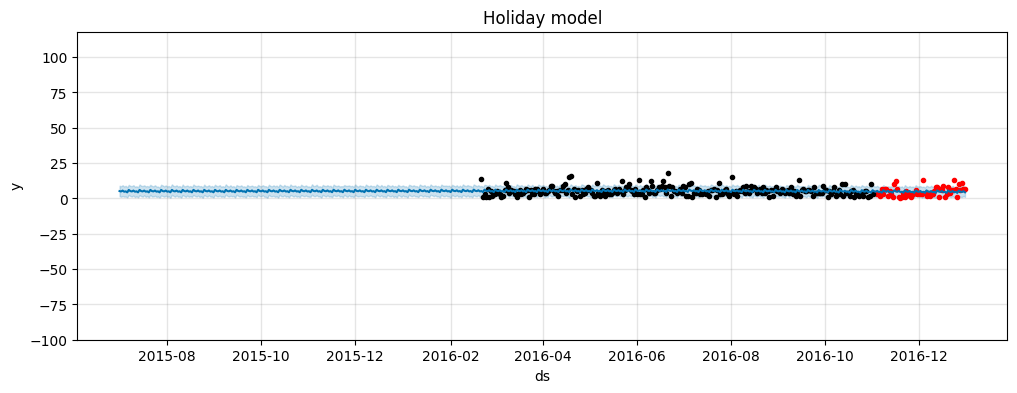

02:20:55 - cmdstanpy - INFO - Chain [1] start processing
02:20:55 - cmdstanpy - INFO - Chain [1] done processing


The SMAPE score is : 0.00000


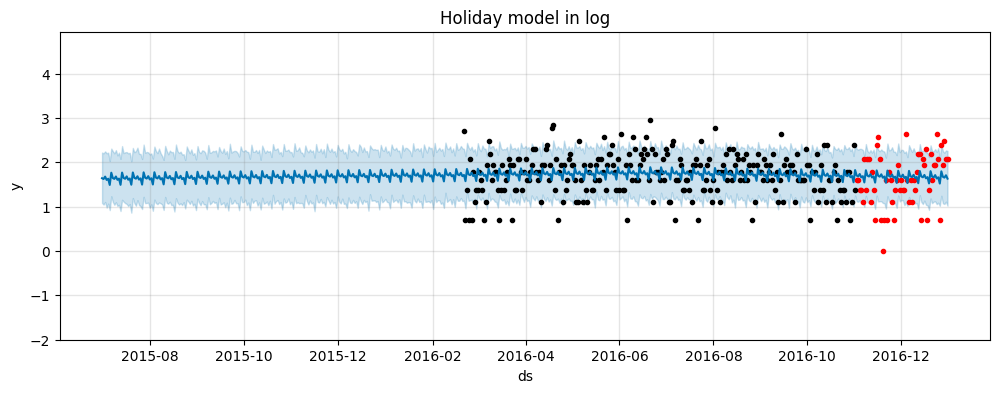

02:20:56 - cmdstanpy - INFO - Chain [1] start processing
02:20:56 - cmdstanpy - INFO - Chain [1] done processing


The SMAPE score is : 0.00000


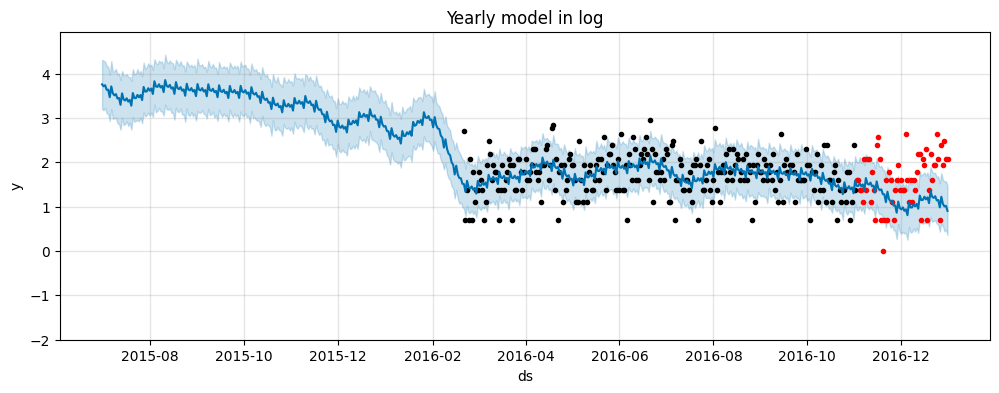

The SMAPE score is : 0.00000


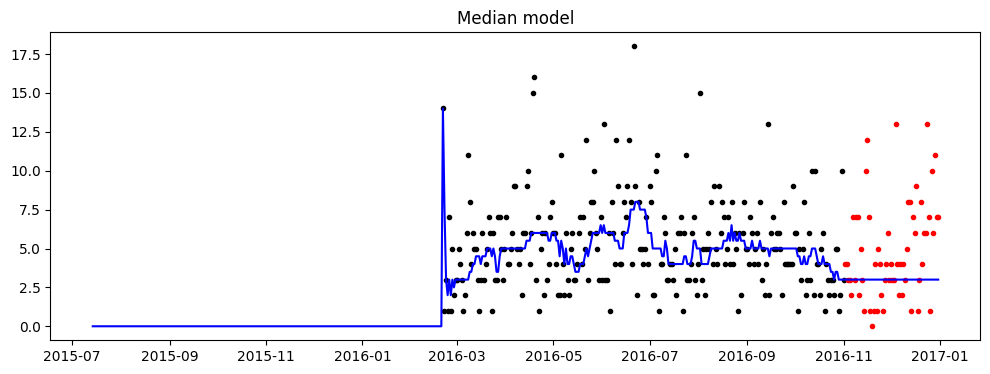

The SMAPE score is : 0.61357


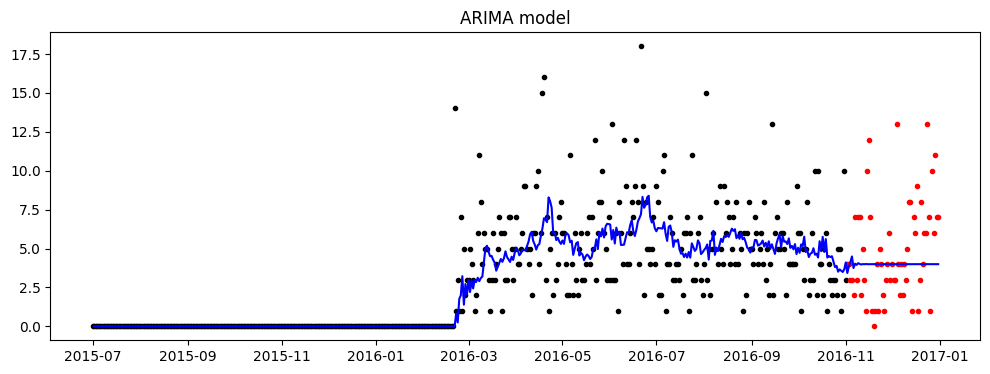

The SMAPE score is : 0.56037


In [40]:
train.iloc[[14211]]

df_train = extract_series(X_train, 14211, 5)
df_actual = extract_series(y_train, 14211, 5)
lang = X_train.iloc[14211, 1]
title = X_train.iloc[14211, 4]
print(title)
score = holiday_model(df_train.copy(), df_actual.copy(), review=True,lang = lang)
print("The SMAPE score is : %.5f" % score)

score = holiday_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = yearly_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

# if there is too many zero, just use normal is OK.
score = median_model(df_train.copy(), df_actual.copy(), 14, review=True)
print("The SMAPE score is : %.5f" % score)

score = arima_model(df_train.copy(), df_actual.copy(), 7, 1, 2, review=True)
print("The SMAPE score is : %.5f" % score)

#### case 7. Adhoc study

                                                     Page  2015-07-01  \
145057  Mi_adorable_maldición_es.wikipedia.org_all-acc...         NaN   

        2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
145057         NaN         NaN         NaN         NaN         NaN   

        2015-07-07  2015-07-08  2015-07-09  ...  2016-12-22  2016-12-23  \
145057         NaN         NaN         NaN  ...         0.0         0.0   

        2016-12-24  2016-12-25  2016-12-26  2016-12-27  2016-12-28  \
145057         NaN         NaN         NaN         NaN         NaN   

        2016-12-29  2016-12-30  2016-12-31  
145057         NaN         NaN         NaN  

[1 rows x 551 columns]
Mi_adorable_maldición_es.wikipedia.org_all-access_spider


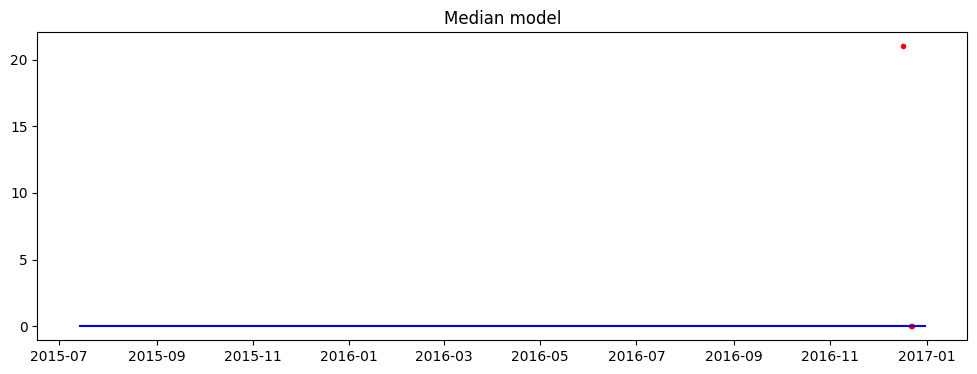

The SMAPE score is : 0.03333
Error in calculating holiday model Dataframe has less than 2 non-NaN rows.
Error in calculating holiday model in log Dataframe has less than 2 non-NaN rows.
Error in calculating yearly model in log Dataframe has less than 2 non-NaN rows.


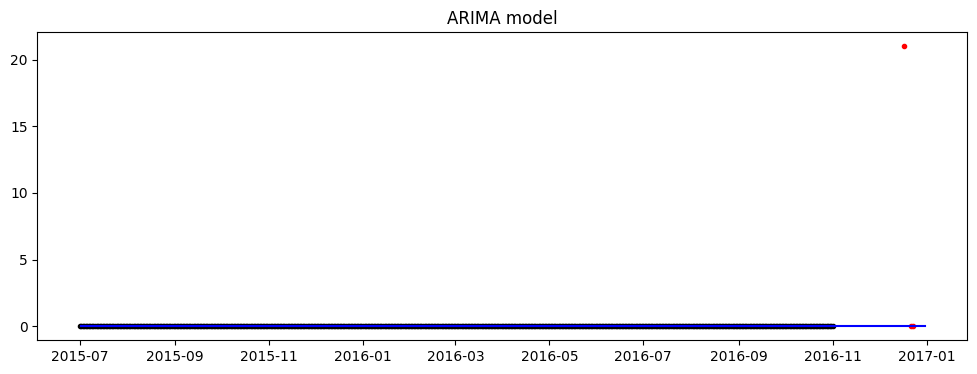

The SMAPE score is : 0.03333


In [41]:
series_num = 145033
series_num = 145057

print(train.iloc[[series_num]])

df_train = extract_series(X_train, series_num, 5)
df_actual = extract_series(y_train, series_num, 5)

lang = X_train.iloc[series_num, 1]
title = X_train.iloc[series_num, 4]
print(title)

try:
    score = median_model(df_train.copy(), df_actual.copy(), 14, review=True)
    print("The SMAPE score is : %.5f" % score)
except Exception as e:
    print("Error in calculating median model", e)
try:
    score = holiday_model(df_train.copy(), df_actual.copy(), review=True,lang = lang)
    print("The SMAPE score is : %.5f" % score)
except Exception as e:
    print("Error in calculating holiday model", e)
    
try:
    score = holiday_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
    print("The SMAPE score is : %.5f" % score)
except Exception as e:
    print("Error in calculating holiday model in log", e)
    
try:
    score = yearly_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
    print("The SMAPE score is : %.5f" % score)
except Exception as e:
    print("Error in calculating yearly model in log", e)

try:
    score = arima_model(df_train.copy(), df_actual.copy(), 7, 1, 2, review=True)
    print("The SMAPE score is : %.5f" % score)
except Exception as e:
    print("Error in calculating arima model", e)

## 4. Selected model performance(validation score) over train dataset

In [42]:
import glob

def read_from_folder(path):
    filenames = glob.glob(path + "/*.csv")

    dfs = []
    for filename in filenames:
        dfs.append(pd.read_csv(filename, index_col=0))
    
    frame = pd.concat(dfs)
    return frame.sort_index()

In [43]:
# TODO: overall validation score in one number.
def validation_score(score_series):
    return score_series.mean()

In [44]:
valid_fn = r"/kaggle/working/validation_score.csv"
valid_score_data = pd.read_csv(valid_fn, index_col=0)

print(valid_score_data[0:10])


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/validation_score.csv'

### Simple median model

In [ ]:
# Check which model is the best
print("Validation score for median model (7 days) is: %.6f" % validation_score(valid_score_data['median7']))
print("Validation score for median model (14 days) is: %.6f" % validation_score(valid_score_data['median14']))
print("Validation score for median model (21 days) is: %.6f" % validation_score(valid_score_data['median21']))
print("Validation score for median model (28 days) is: %.6f" % validation_score(valid_score_data['median28']))
print("Validation score for median model (35 days) is: %.6f" % validation_score(valid_score_data['median35']))
print("Validation score for median model (42 days) is: %.6f" % validation_score(valid_score_data['median42']))
print("Validation score for median model (49 days) is: %.6f" % validation_score(valid_score_data['median49']))

fig, axs  = plt.subplots(4,2,figsize=(12,12))
valid_score_data['median7'].plot.hist(bins=40, ax=axs[0][0])
valid_score_data['median14'].plot.hist(bins=40, ax=axs[0][1])
valid_score_data['median21'].plot.hist(bins=40, ax=axs[1][0])
valid_score_data['median28'].plot.hist(bins=40, ax=axs[1][1])
valid_score_data['median35'].plot.hist(bins=40, ax=axs[2][0])
valid_score_data['median42'].plot.hist(bins=40, ax=axs[2][1])
valid_score_data['median49'].plot.hist(bins=40, ax=axs[3][0])


### median model - weekday, weekend, holiday

In [ ]:
print("Validation score for median model w/holiday (7 days) is: %.6f" % validation_score(valid_score_data['median7_h']))
print("Validation score for median model w/holiday (14 days) is: %.6f" % validation_score(valid_score_data['median14_h']))
print("Validation score for median model w/holiday (21 days) is: %.6f" % validation_score(valid_score_data['median21_h']))
print("Validation score for median model w/holiday (28 days) is: %.6f" % validation_score(valid_score_data['median28_h']))
print("Validation score for median model w/holiday (35 days) is: %.6f" % validation_score(valid_score_data['median35_h']))
print("Validation score for median model w/holiday (42 days) is: %.6f" % validation_score(valid_score_data['median42_h']))
print("Validation score for median model w/holiday (49 days) is: %.6f" % validation_score(valid_score_data['median49_h']))

fig, axs  = plt.subplots(4,2,figsize=(12,12))
valid_score_data['median7_h'].plot.hist(bins=40, ax=axs[0][0])
valid_score_data['median14_h'].plot.hist(bins=40, ax=axs[0][1])
valid_score_data['median21_h'].plot.hist(bins=40, ax=axs[1][0])
valid_score_data['median28_h'].plot.hist(bins=40, ax=axs[1][1])
valid_score_data['median35_h'].plot.hist(bins=40, ax=axs[2][0])
valid_score_data['median42_h'].plot.hist(bins=40, ax=axs[2][1])
valid_score_data['median49_h'].plot.hist(bins=40, ax=axs[3][0])

### ARIMA model

### Facebook model

In [ ]:
print("Validation score for holiday model is: %.6f" % validation_score(valid_score_data['holiday']))
print("Validation score for holiday model w/log is: %.6f" % validation_score(valid_score_data['holiday_log']))
print("Validation score for yearly model w/log is: %.6f" % validation_score(valid_score_data['yearly_log']))

fig, axs  = plt.subplots(3,1,figsize=(12,12))
valid_score_data['holiday'].plot.hist(bins=40, ax=axs[0])
axs[0].set_title("Holiday model")
valid_score_data['holiday_log'].plot.hist(bins=40, ax=axs[1])
axs[1].set_title("Holiday model w/log")
valid_score_data['yearly_log'].plot.hist(bins=40, ax=axs[2])
axs[2].set_title("Yearly model w/log")

### mixed model

In [ ]:
def model_to_use( median, holiday_log, yearly_log):
    result = median
    if(median * 1 > yearly_log):
        result = yearly_log
    elif(median * 1 > holiday_log):
        result = holiday_log
        
    return result

model_score = valid_score_data.apply(lambda x: model_to_use( x['median14'], x['holiday_log'], x['yearly_log']), axis=1)

print("Validation score for a proposed model is: %.6f" % validation_score(model_score))
model_score.plot.hist(bins=40)

In [ ]:
model_score_2 = valid_score_data.min(axis=1)
print("Best possible Validation score for a mixed model is: %.6f" % validation_score(model_score_2))

model_score_2.plot.hist(bins=40)